# CellRank Meets RNA Velocity

## Preliminaries

In this tutorial, you will learn how to:

- use {mod}`scvelo` to compute RNA velocity {cite}`bergen:20,manno:18`.  
- set up CellRank's {class}`cellrank.kernels.VelocityKernel` and compute a transition matrix based on RNA velocity. 
- combine the {class}`~cellrank.kernels.VelocityKernel` with the {class}`~cellrank.kernels.ConnectivityKernel` to emphasize gene expression similarity. 
- visualize the transition matrix in a low-dimensional embedding. 

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/main/tutorials/cellrank_meets_rna_velocity.ipynb).

:::{figure-md} velocity-kernel

<img src="../_static/img/002_velocity_kernel_extended.jpg" alt="The VelocityKernel restricts velocity vectors to their local neighborhood to estimate a transition matrix. " width="800px">

**Using RNA velocity in high dimensions to analyze cellular transitions:** We combine RNA velocity with transcriptomic similarity in high dimensions to compute a matrix of cell-cell transition probabilities. 
:::

:::{note}
If you want to run this on your own data, you will need:

- a scRNA-seq dataset which has been preprocessed to contain unspliced & spliced counts using a software like the [Velocyto command line tool](http://velocyto.org/velocyto.py/tutorial/index.html#running-the-cli). 

:::

:::{note}

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). You can also contact us using info@cellrank.org.  

:::

### Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank

In [2]:
import numpy as np

import cellrank as cr
import scanpy as sc
import scvelo as scv

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

Global seed set to 0


In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of mouse pancreas development at embryonic day (E) 15.5, which can be conveniently acessed through {mod}`~cellrank.datasets.pancreas` {cite}`bastidas-ponce:19, bergen:20`. 

We visualize the fraction of spliced/unspliced reads; these are required to estimate RNA velocity. 

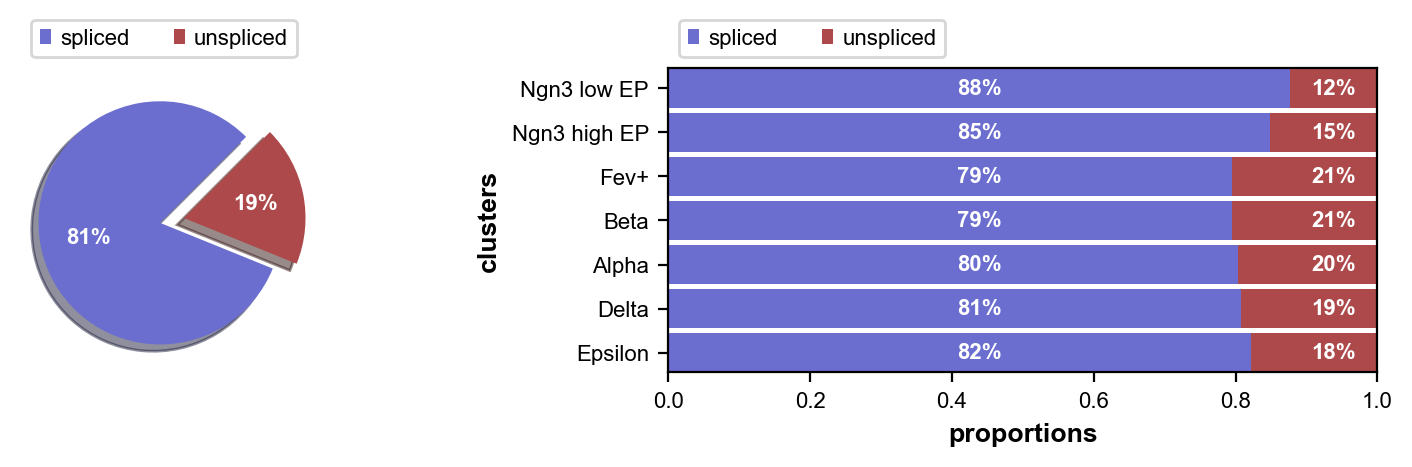

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
adata = cr.datasets.pancreas()
scv.pl.proportions(adata)
adata

### Preprocess the data

Filter out genes which don't have enough spliced/unspliced counts, normalize and log transform the data and restrict to the top highly variable genes. Further, compute principal components and moments for velocity estimation. 

In [5]:
scv.pp.filter_and_normalize(
    adata, min_shared_counts=20, n_top_genes=2000, subset_highly_variable=False
)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30, random_state=0)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22024 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### Run scVelo

We will use scVelo's {func}`dynamical model <scvelo.tl.recover_dynamics>` to estimate model parameters. 

:::{note}

Please make sure to have at least version `0.2.3` of scVelo installed to make use **parallelisation** in `scv.tl.recover_dynamics`. On my MacBook, using 8 cores, the below cell takes about 1 min to execute. 

:::

In [6]:
scv.tl.recover_dynamics(adata, n_jobs=8)

recovering dynamics (using 8/8 cores)


  0%|          | 0/1078 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:01:11) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


Once we have the parameters, we can use these to compute the actual velocities. 

In [7]:
scv.tl.velocity(adata, mode="dynamical")

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


We'll use CellRank to visualize the velocities in an embedding further down below. 

## Combine RNA velocity with expression similarity in high dimensions

### Set up the VelocityKernel

Set up the {class}`~cellrank.kernels.VelocityKernel` from the {class}`~anndata.AnnData` object containing the scVelo-computed velocities. 

In [8]:
vk = cr.kernels.VelocityKernel(adata)

Use the {class}`~cellrank.kernels.VelocityKernel` to compute a transition matrix by correlating each cell's velocity vector with the displacement vectors towards nearest neighbors, directly in high-dimensional gene expression space. 

:::{figure-md} velocity-vectors

<img src="../_static/img/002_velocity_kernel.jpg" alt="Correlating velocity vectors with transcriptomic displacements gives sparse transition probabilities. " width="800px">

**Computing transition probabilities:** We correlate each cell's velocity vector with the transcriptomic displacement vectors towards nearest neighbors. 
:::

We do this using the {meth}`~cellrank.kernels.VelocityKernel.compute_transition_matrix` method. 

In [9]:
vk.compute_transition_matrix()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/2531 [00:00<?, ?cell/s]

Using `softmax_scale=4.0132`


  0%|          | 0/2531 [00:00<?, ?cell/s]

    Finish (0:00:01)


VelocityKernel[n=2531, model='deterministic', similarity='correlation', softmax_scale=4.013]

By default, we use the `deterministic` mode to compute the transiton matrix. If you want to propagate uncertainty in the velocity vectors, check out the `stochastic` and `monte_carlo` modes. The `stochastic` mode estimates a distribution over velocity vectors using the KNN graph and propagates this distribution into the transition matrix using an analytical approximation. 

:::{figure-md} velocity-vectors

<img src="../_static/img/002_propagating_uncertainty.jpg" alt="Propagating uncertainty from velocity vectors into cell state transitions. " width="800px">

**Propagating velocity uncertainty:** CellRank can propagate estimated velocity uncertainties into transition probabilities.  
:::

:::{note}

Please check out our "CellRank for directed single-cell fate mapping"  paper to learn more on uncertainty propagation and how it makes computations more robust to noise {cite}`lange:22`.

:::

### Combine with gene expression similarity

RNA velocity can be a very noise quantity; to make our computations more robust, we combine the {class}`~cellrank.kernels.VelocityKernel` with the similarity-based {class}`~cellrank.kernels.ConnectivityKernel`. 

In [10]:
ck = cr.kernels.ConnectivityKernel(adata)
ck.compute_transition_matrix()

combined_kernel = 0.8 * vk + 0.2 * ck

Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


Above, we combined the two kernels with custom weights given to each. The same syntax can be used to combine any number of CellRank kernels, see the {doc}`getting started tutorial <getting_started>`. 

Let's print the combined kernel object to see what it contains: 

In [11]:
print(combined_kernel)

(0.8 * VelocityKernel[n=2531] + 0.2 * ConnectivityKernel[n=2531])


This tells us about the kernels we combined, the weights we used to combine them, and the parameters that went into transition matrix computation for each kernel. Check out the {class}`API <cellrank.kernels.VelocityKernel>` to learn more about the parameters. Next, let's explore ways to visualize the computed transition matrix. 

### Visualize the transition matrix 

Similar to {mod}`scvelo` {cite}`bergen:20` and [velocyto](http://velocyto.org/) {cite}`manno:18`, CellRank visualizes the transition matrix in any low dimensional embedding (UMAP, t-SNE, PCA, Diffmap, etc.) via arrows or streamlines. 

Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:00)


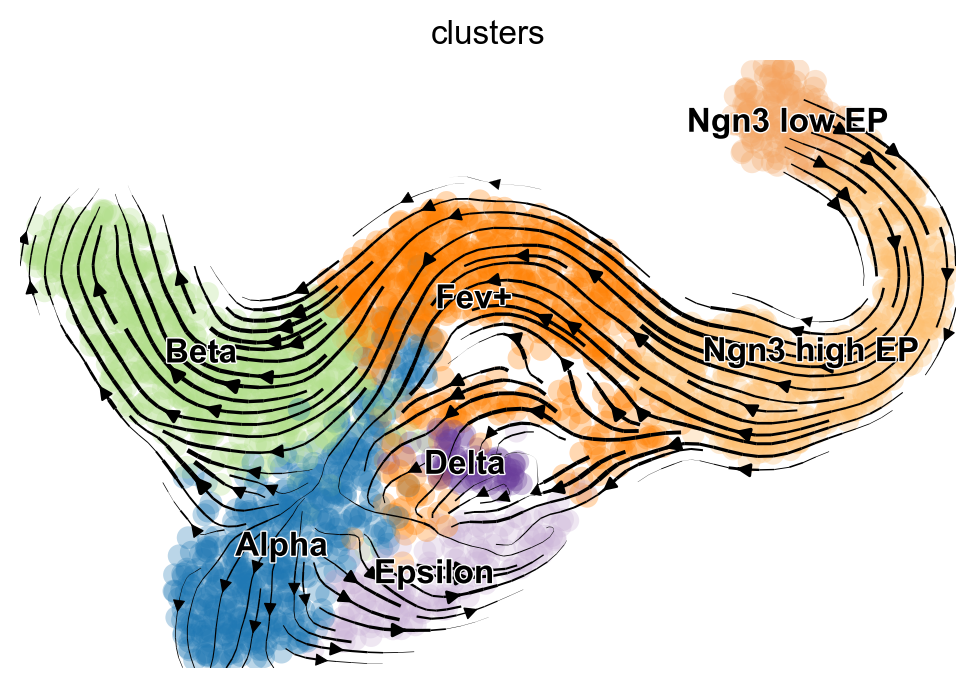

In [12]:
vk.plot_projection()

As shown before in the scVelo publication {cite}`bergen:20`, the projected velocity vectors capture the overall trend in this system: *Neurogenin 3* low endocrine progenitor cells (Ngn3 low EP) gradually transition via indermediate stages towards terminal, hormone producing Alpha, Beta, Epsilon and Delta cells. Another way to visualize this is via random walks. 

Simulating `100` random walks of maximum length `200`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:01)
Plotting random walks


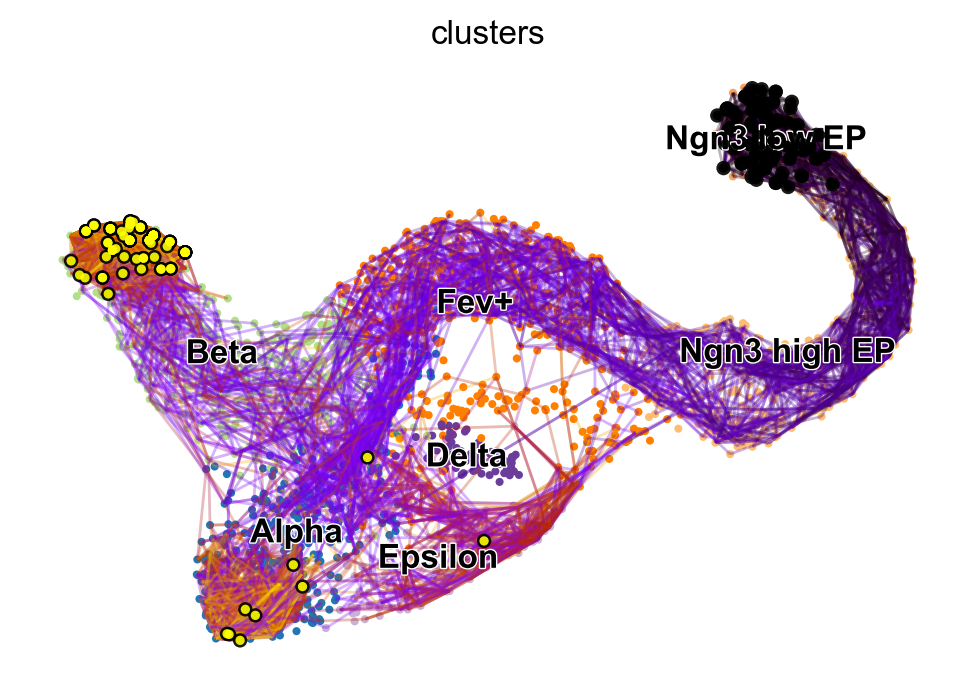

In [13]:
vk.plot_random_walks(start_ixs={"clusters": "Ngn3 low EP"}, max_iter=200, seed=0)

We simulated random walks starting in the `Ngn3 low EP` cluster. Black and yellow dots denote the start and end points of a random walk, respectively. In agreement with known biology,  the Beta cluster is dominant at E15.5 {cite}`bastidas-ponce:19`. 

:::{note}

Take these low-dimensional representations with a grain of salt; streamlines in a low-dimensional embeddings are very biased by the topology of that embedding. They often oversmooth that actual dynamics, or obscure them entirely. Random walks are a better alternative; these are sampled directly from the Markov chain and don't depend on the low dimensional embedding. Additionally, we recommend analyzing high-dimensional dynamics using {mod}`~cellrank.estimators`. 

:::

## Closing matters

### Write results to file

We will use the kernel computed here in other tutorials to demonstrate downstream applications; for this reason, we write the kernel attributes to the underlying {class}`anndata.AnnData` object here and save to disk. In other tutorials, we can then reconstruct the kernel from the saved object. 

In [14]:
vk.write_to_adata()
adata.write(
    "datasets/ML_2023-06-08_pancreas_with_transition_matrix.h5ad", compression="gzip"
)

### What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix using RNA velocity and gene expression similarity and how it can be visualized in low dimensions {cite}`lange:22, bergen:20, manno:18`. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend...

- going through the {doc}`initial and terminal states tutorial <initial_terminal>` to learn how to use the transition matrix to automatically identify initial and terminal states. 
- reading our "CellRank for directed single-cell fate mapping" paper to learn more about the methods we used here {cite}`lange:22`. 
- taking a look at the {class}`API <cellrank.kernels.VelocityKernel> ` to learn about parameter values you can use to adapt these computations to your data. 

### Package versions

We used the following package versions to generate this tutorial: 

In [15]:
cr.logging.print_versions()

cellrank==1.5.1+gedbc651e scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
